Goal of this notebook: implement some basic RNN/LSTM/GRU to _forecast_ trajectories based on VIRAT and/or the custom _hof_ dataset.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt # Visualization 
import torch.nn as nn
import pandas_helper_calc  # noqa # provides df.calc.derivative()
import pandas as pd
import cv2
import pathlib
from tqdm.autonotebook import tqdm

/home/ruben/suspicion/trap/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
FPS = 12
# SRC_CSV = "EXPERIMENTS/hofext-maskrcnn/all.txt"
# SRC_CSV = "EXPERIMENTS/raw/generated/train/tracks.txt"
SRC_CSV = "EXPERIMENTS/raw/hof-meter-maskrcnn2/train/tracks.txt"
SRC_CSV = "EXPERIMENTS/20240426-hof-yolo/train/tracked.txt"
SRC_CSV = "EXPERIMENTS/raw/hof2/train/tracked.txt"
# SRC_H = "../DATASETS/hof/webcam20231103-2-homography.txt"
SRC_H = None
CACHE_DIR = "EXPERIMENTS/cache/hof2/"
# SMOOTHING = True # hof-yolo is already smoothed, hof2 isn't
# SMOOTHING_WINDOW=3 #2

In [3]:
in_fields = ['x', 'y', 'vx', 'vy', 'ax', 'ay'] #, 'dt'] (WARNING: dt column contains NaN)
# out_fields = ['v', 'heading']
# velocity cannot be negative, and heading is circular (modulo), this makes it harder to optimise than a linear space, so try to use components
# an we can use simple MSE loss (I guess?)
out_fields = ['dx', 'dy']
SAMPLE_STEP = 5 # 1/5, for 12fps leads to effectively 12/5=2.4fps
GRID_SIZE = 2 # round items on a grid of 2 points per meter (None to disable rounding)
window = 8 #int(FPS*1.5 / SAMPLE_STEP)

In [4]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Hyperparameters
input_size = len(in_fields)   #in_d
hidden_size = 64                       # hidden_d
num_layers = 1                         # num_hidden
output_size = len(out_fields) # out_d
learning_rate = 0.005 #0.01 #0.005
batch_size = 512
num_epochs = 1000


cuda


In [5]:
cache_path = pathlib.Path(CACHE_DIR)
cache_path.mkdir(parents=True, exist_ok=True)

In [6]:
from pathlib import Path
from trap.tools import load_tracks_from_csv
from trap.tools import filter_short_tracks, normalise_position

data= load_tracks_from_csv(Path(SRC_CSV), FPS, GRID_SIZE, SAMPLE_STEP )

Samping 1/5, of 412098 items
Done sampling kept 83726 items


In [7]:
# create x-norm, y_norm columns
data, mu, std = normalise_position(data)
data = filter_short_tracks(data, window+1)

The dataset is a bit crappy because it has different frame step: ranging from predominantly 1 and 2 to sometimes have 3 and 4 as well. This inevitabily leads to difference in speed caluclations

In [8]:
track_ids = data.index.unique('track_id').to_numpy()
np.random.shuffle(track_ids)
test_offset_idx = int(len(track_ids) * .8)
training_ids, test_ids = track_ids[:test_offset_idx], track_ids[test_offset_idx:]
print(f"{len(training_ids)} training tracks, {len(test_ids)} test tracks")

1606 training tracks, 402 test tracks


here, draw out a sample track to see if it looks alright. **unfortunately the imate isn't mapped properly**.

4789


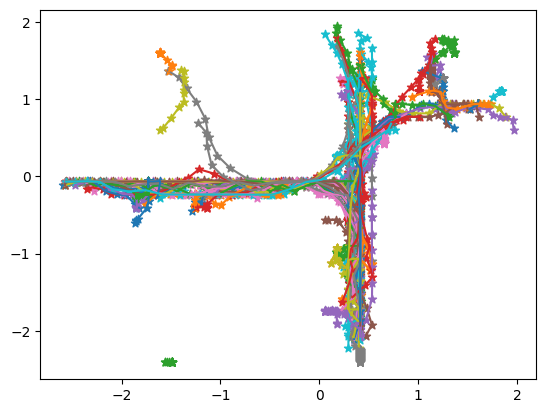

In [9]:
import random
# if H:
#     img_src = "../DATASETS/hof/webcam20231103-2.png"
#     # dst = cv2.warpPerspective(img_src,H,(2500,1920))
#     src_img = cv2.imread(img_src)
#     print(src_img.shape)
#     h1,w1 = src_img.shape[:2]
#     corners = np.float32([[0,0], [w1, 0], [0, h1], [w1, h1]])

#     print(corners)
#     corners_projected = cv2.perspectiveTransform(corners.reshape((-1,4,2)), H)[0]
#     print(corners_projected)
#     [xmin, ymin] = np.int32(corners_projected.min(axis=0).ravel() - 0.5)
#     [xmax, ymax] = np.int32(corners_projected.max(axis=0).ravel() + 0.5)
#     print(xmin, xmax, ymin, ymax)

#     dst = cv2.warpPerspective(src_img,H, (xmax, ymax))
#     def plot_track(track_id: int):
#         plt.gca().invert_yaxis()

#         plt.imshow(dst, origin='lower', extent=[xmin/100-mean_x, xmax/100-mean_x, ymin/100-mean_y, ymax/100-mean_y])
#         # plot scatter plot with x and y data 
        
#         ax = plt.scatter(
#             filtered_data.loc[track_id,:]['proj_x'],
#             filtered_data.loc[track_id,:]['proj_y'],
#             marker="*") 
#         ax.axes.invert_yaxis()
#         plt.plot(
#             filtered_data.loc[track_id,:]['proj_x'],
#             filtered_data.loc[track_id,:]['proj_y']
#         )
# else:
def plot_track(track_id: int):
    ax = plt.scatter(
        data.loc[track_id,:]['x_norm'],
        data.loc[track_id,:]['y_norm'],
        marker="*") 
    plt.plot(
        data.loc[track_id,:]['x_norm'],
        data.loc[track_id,:]['y_norm']
    )

# print(filtered_data.loc[track_id,:]['proj_x'])
# _track_id = 2188
_track_id = random.choice(track_ids)
print(_track_id)
plot_track(_track_id)

for track_id in random.choices(track_ids, k=100):
    plot_track(track_id)
    
# print(mean_x, mean_y)

Now make the dataset:

In [10]:
# a=filtered_data.loc[1]
# min(a.index.tolist())
data

l           t           w           h          x  \
track_id frame_id                                                               
1        342.0     1393.736572    0.000000   67.613647  121.391151  13.244408   
         347.0     1393.844849   12.691238   86.482910  156.264786  13.500384   
         352.0     1405.273438   36.675903   90.329956  176.461975  13.509425   
         357.0     1421.215698   76.261253   91.465088  181.133682  13.500221   
         362.0     1438.374268  115.362549   84.298584  172.143616  13.499658   
...                        ...         ...         ...         ...        ...   
5030     32702.0   1705.054635  749.467887  132.149004  182.105042  14.000000   
         32707.0   1703.756025  749.703112  131.216670  181.961914  14.000000   
         32712.0   1702.457415  749.938337  130.284337  181.818787  14.000000   
         32717.0   1701.158805  750.173562  129.352003  181.675659  14.000000   
         32722.0   1702.384766  750.754517  123.435425  180.945618  14.000000   

                           y  state  diff  x_raw  y_raw  ...            vx  \
track_id frame_id                                        ...                 
1        342.0      2.414339    2.0   NaN   13.5    2.5  ...  6.143418e-01   
         347.0      2.993156    2.0   5.0   13.5    3.0  ...  6.143418e-01   
         352.0      3.650656    2.0   5.0   13.5    3.5  ...  2.169933e-02   
         357.0      4.282279    2.0   5.0   13.5    4.5  ... -2.209058e-02   
         362.0      4.743787    2.0   5.0   13.5    4.5  ... -1.349331e-03   
...                      ...    ...   ...    ...    ...  ...           ...   
5030     32702.0   10.495261    1.0   5.0   14.0   10.5  ...  1.654143e-12   
         32707.0   10.499609    1.0   5.0   14.0   10.5  ...  7.418066e-13   
         32712.0   10.500165    1.0   5.0   14.0   10.5  ... -4.263256e-14   
         32717.0   10.500019    1.0   5.0   14.0   10.5  ... -2.984279e-14   
         32722.0   10.499985    2.0   5.0   14.0   10.5  ...  0.000000e+00   

                         vy            ax        ay         v         a  \
track_id frame_id                                                         
1        342.0     1.389160 -1.422342e+00  0.453213  1.518941  0.142097   
         347.0     1.389160 -1.422342e+00  0.453213  1.518941  0.142097   
         352.0     1.577999 -1.422342e+00  0.453213  1.578149  0.142097   
         357.0     1.515896 -1.050958e-01 -0.149049  1.516057 -0.149020   
         362.0     1.107618  4.977900e-02 -0.979866  1.107619 -0.980250   
...                     ...           ...       ...       ...       ...   
5030     32702.0  -0.029145  4.967546e-11  0.657171  0.029145 -0.657171   
         32707.0   0.010435 -2.189608e-12  0.094992  0.010435 -0.044905   
         32712.0   0.001334 -1.882654e-12 -0.021841  0.001334 -0.021841   
         32717.0  -0.000350  3.069545e-14 -0.004042  0.000350 -0.002362   
         32722.0  -0.000082  7.162271e-14  0.000644  0.000082 -0.000644   

                      heading     d_heading    x_norm    y_norm  
track_id frame_id                                                
1        342.0      66.143088  5.536579e+01  0.353449 -1.768217  
         347.0      66.143088  5.536579e+01  0.414443 -1.574517  
         352.0      89.212166  5.536579e+01  0.416598 -1.354485  
         357.0      90.834891  3.894540e+00  0.414404 -1.143113  
         362.0      90.069799 -1.836220e+00  0.414270 -0.988670  
...                       ...           ...       ...       ...  
5030     32702.0   270.000000  1.644812e-08  0.533492  0.936057  
         32707.0    90.000000 -4.320000e+02  0.533492  0.937512  
         32712.0    90.000000  1.416898e-08  0.533492  0.937698  
         32717.0   270.000000  4.320000e+02  0.533492  0.937649  
         32722.0   270.000000  1.172430e-08  0.533492  0.937638  

[80035 rows x 24 columns]

In [11]:
for field in in_fields + out_fields:
    print(field, data[field].isnull().values.any())

x False
y False
vx False
vy False
ax False
ay False
dx False
dy False


In [12]:
def create_dataset(data, track_ids, window, only_last=False):
    X, y, = [], []
    factor = SAMPLE_STEP if SAMPLE_STEP is not None else 1
    for track_id in tqdm(track_ids):
        df = data.loc[track_id]
        # print(df)
        start_frame = min(df.index.tolist())
        for step in range(len(df)-window-1):
            i = int(start_frame) + (step*factor)
            # print(step, int(start_frame), i)
            feature = df.loc[i:i+(window*factor)][in_fields]
            # target = df.loc[i+1:i+window+1][out_fields]
            # print(i, window*factor, factor, i+window*factor+factor, df['idx_in_track'])
            # print(i+window*factor+factor)
            if only_last:
                target = df.loc[i+window*factor+factor][out_fields]
            else:
                target = df.loc[i+factor:i+window*factor+factor][out_fields]

            X.append(feature.values)
            y.append(target.values)
            
    return torch.tensor(np.array(X), dtype=torch.float), torch.tensor(np.array(y), dtype=torch.float)

X_train, y_train = create_dataset(data, training_ids, window)
X_test, y_test = create_dataset(data, test_ids, window)

  0%|          | 0/1606 [00:00<?, ?it/s]

100%|██████████| 402/402 [00:06<00:00, 60.38it/s]


In [13]:
X_train, y_train = X_train.to(device=device), y_train.to(device=device)
X_test, y_test = X_test.to(device=device), y_test.to(device=device)

In [106]:
from torch.utils.data import TensorDataset, DataLoader
dataset_train = TensorDataset(X_train, y_train)
loader_train = DataLoader(dataset_train, shuffle=True, batch_size=batch_size)
dataset_test = TensorDataset(X_test, y_test)
loader_test = DataLoader(dataset_test, shuffle=False, batch_size=batch_size)

Model give output for all timesteps, this should improve training. But we use only the last timestep for the prediction process

## RNN

In [15]:
class SimpleRnn(nn.Module):
  def __init__(self, in_d=2, out_d=2, hidden_d=4, num_hidden=1):
    super(SimpleRnn, self).__init__()
    self.rnn = nn.RNN(input_size=in_d, hidden_size=hidden_d, num_layers=num_hidden)
    self.fc = nn.Linear(hidden_d, out_d)

  def forward(self, x, h0):
    r, h = self.rnn(x, h0)
    # r = r[:, -1,:]
    y = self.fc(r)  # no activation on the output
    return y, h
rnn = SimpleRnn(input_size, output_size, hidden_size, num_layers).to(device)

## LSTM

For optional LSTM-GAN, see https://discuss.pytorch.org/t/how-to-use-lstm-to-construct-gan/12419

Or VAE (variational Auto encoder):

> The only constraint on the latent vector representation for traditional autoencoders is that latent vectors should be easily decodable back into the original image. As a result, the latent space $Z$ can become disjoint and non-continuous. Variational autoencoders try to solve this problem. [Alexander van de Kleut](https://avandekleut.github.io/vae/)

For LSTM based generative VAE: https://github.com/Khamies/LSTM-Variational-AutoEncoder/blob/main/model.py

http://web.archive.org/web/20210119121802/https://towardsdatascience.com/time-series-generation-with-vae-lstm-5a6426365a1c?gi=29d8b029a386

https://youtu.be/qJeaCHQ1k2w?si=30aAdqqwvz0DpR-x&t=687 VAE generate mu and sigma of a Normal distribution. Thus, they don't map the input to a single point, but a gausian distribution.

In [328]:
class LSTMModel(nn.Module):
    # input_size : number of features in input at each time step
    # hidden_size : Number of LSTM units 
    # num_layers : number of LSTM layers 
    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__() #initializes the parent class nn.Module
        # We _could_ train the h0: https://discuss.pytorch.org/t/learn-initial-hidden-state-h0-for-rnn/10013 
        # self.lin1 = nn.Linear(input_size, hidden_size)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        # self.activation_v = nn.LeakyReLU(.01)
        # self.activation_heading = torch.remainder()

    
    def get_hidden_state(self, batch_size, device):
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return (h, c)

    def forward(self, x, hidden_state): # defines forward pass of the neural network
        # out = self.lin1(x)
        
        out, hidden_state = self.lstm(x, hidden_state)
        # extract only the last time step, see https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
        # print(out.shape)
        # TODO)) Might want to remove this below: as it might improve training
        # out = out[:, -1,:]
        # print(out.shape)
        out = self.linear(out)
        
        #  torch.remainder(out[1], 360)
        # print('o',out.shape)
        return out, hidden_state

lstm = LSTMModel(input_size, hidden_size, num_layers).to(device)


In [329]:
# model = rnn
model = lstm


In [330]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

In [331]:
def evaluate():
    # toggle evaluation mode
    model.eval()
    with torch.no_grad():
        batch_size, seq_len, feature_dim = X_train.shape
        y_pred, _ = model(
            X_train.to(device=device),
            model.get_hidden_state(batch_size, device)
            )
        train_rmse = torch.sqrt(loss_fn(y_pred, y_train))
        # print(y_pred)

        batch_size, seq_len, feature_dim = X_test.shape
        y_pred, _ = model(
            X_test.to(device=device),
            model.get_hidden_state(batch_size, device)
            )
        # print(loss_fn(y_pred, y_test))
        test_rmse = torch.sqrt(loss_fn(y_pred, y_test))
    print("Epoch ??: train RMSE %.4f, test RMSE %.4f" % ( train_rmse, test_rmse))

def load_most_recent():
    paths = list(cache_path.glob(f"checkpoint-{model._get_name()}_*.pt"))
    if len(paths) < 1:
        print('Nothing found to load')
        return None, None
    paths.sort()

    print(f"Loading {paths[-1]}")
    return load_cache(path=paths[-1])

def load_cache(epoch=None, path=None):
    if path is None:
        if epoch is None:
            raise RuntimeError("Either path or epoch must be given")
        path = cache_path / f"checkpoint-{model._get_name()}_{epoch:05d}.pt"
    else:
        print (path.stem)
        epoch = int(path.stem[-5:])

    cached = torch.load(path)
    
    optimizer.load_state_dict(cached['optimizer_state_dict'])
    model.load_state_dict(cached['model_state_dict'])
    return epoch, cached['loss']
    

def cache(epoch, loss):
    path = cache_path / f"checkpoint-{model._get_name()}_{epoch:05d}.pt"
    print(f"Cache to {path}")
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, path)


TODO)) See [this notebook](https://www.cs.toronto.edu/~lczhang/aps360_20191/lec/w08/rnn.html) For initialization (with random or not) and the use of GRU

In [332]:
start_epoch, loss = load_most_recent()
if start_epoch is None:
    start_epoch = 0
else:
    print(f"starting from epoch {start_epoch} (loss: {loss})")
    evaluate()

loss_log = []
# Train Network
for epoch in tqdm(range(start_epoch+1,num_epochs+1)):
    # toggle train mode
    model.train()
    for batch_idx, (x, targets) in enumerate(loader_train):
        # Get x to cuda if possible
        x = x.to(device=device).squeeze(1)
        targets = targets.to(device=device)

        # forward
        scores, _ = model(
            x,
            torch.zeros(num_layers, x.shape[2], hidden_size, dtype=torch.float).to(device=device),
            torch.zeros(num_layers, x.shape[2], hidden_size, dtype=torch.float).to(device=device)
            )
        # print(scores)
        loss = loss_fn(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent update step/adam step
        optimizer.step()

        loss_log.append(loss.item())

    if epoch % 5 != 0:
        continue

    cache(epoch, loss)
    evaluate()

evaluate()

Loading EXPERIMENTS/cache/hof2/checkpoint-LSTMModel_01000.pt
checkpoint-LSTMModel_01000
starting from epoch 1000 (loss: 0.014368701726198196)
Epoch ??: train RMSE 0.0849, test RMSE 0.0866


0it [00:00, ?it/s]

Epoch ??: train RMSE 0.0849, test RMSE 0.0866


In [333]:
# print(loss)
# print(len(loss_log))
# plt.plot(loss_log)
# plt.ylabel('Loss')
# plt.xlabel('iteration')
# plt.show()

In [335]:
model.eval()

with torch.no_grad():
    y_pred, _ = model(X_train.to(device=device),
                      model.get_hidden_state(X_train.shape[0], device))
    
    print(y_pred.shape, y_train.shape)
# y_train, y_pred

torch.Size([49999, 9, 2]) torch.Size([49999, 9, 2])


In [336]:
import scipy

def ceil_away_from_0(a):
    return np.sign(a) * np.ceil(np.abs(a))


In [343]:
def predict_and_plot(model, feature, steps = 50):
    lenght = feature.shape[0]

    dt = (1/ FPS) * SAMPLE_STEP

    trajectory = feature

    # feature = filtered_data.loc[_track_id,:].iloc[:5][in_fields].values
    # nxt = filtered_data.loc[_track_id,:].iloc[5][out_fields]
    with torch.no_grad():
        # h = torch.zeros(num_layers, window+1, hidden_size, dtype=torch.float).to(device=device)
        # c = torch.zeros(num_layers, window+1, hidden_size, dtype=torch.float).to(device=device)
        h = torch.zeros(num_layers, 1, hidden_size, dtype=torch.float).to(device=device)
        c = torch.zeros(num_layers, 1, hidden_size, dtype=torch.float).to(device=device)
        hidden_state = (h, c)
        # X = torch.tensor([feature], dtype=torch.float).to(device)
        # y, (h, c) = model(X, h, c)
        for i in range(steps):
            # predict_f = scipy.ndimage.uniform_filter(feature)
            # predict_f = scipy.interpolate.splrep(feature[:][0], feature[:][1],)
            # predict_f = scipy.signal.spline_feature(feature, lmbda=.1)
            # bathc size of one, so feature as single item in array
            # print(X.shape)
            X = torch.tensor([feature], dtype=torch.float).to(device)
            # print(type(model))
            y, hidden_state, *_ = model(X, hidden_state)
            # print(hidden_state.shape)

            s = y[-1][-1].cpu()

            #  proj_x    proj_y         v     heading          a    d_heading
            # next_step = feature

            dx, dy = s
            
            dx = (dx * GRID_SIZE).round() / GRID_SIZE
            dy = (dy * GRID_SIZE).round() / GRID_SIZE
            vx, vy = dx / dt, dy / dt

            v = np.sqrt(s[0]**2 + s[1]**2)
            heading = (np.arctan2(s[1], s[0])  * 180 / np.pi) % 360
            # a = (v - feature[-1][2]) / dt
            ax = (vx - feature[-1][2]) / dt
            ay = (vx - feature[-1][3]) / dt
            # d_heading = (heading - feature[-1][5])
            # print(s)
            # ['x', 'y', 'vx', 'vy', 'ax', 'ay'] 
            x = feature[-1][0] + dx
            y = feature[-1][1] + dy
            if GRID_SIZE is not None:
                # put points back on grid
                x = (x*GRID_SIZE).round() / GRID_SIZE
                y = (y*GRID_SIZE).round() / GRID_SIZE

            feature = [[x, y, vx, vy, ax, ay]]
            
            trajectory = np.append(trajectory, feature, axis=0)
            # f = [feature[-1][0] + s[0]*dt, feature[-1][1] + s[1]*dt, v, heading, a, d_heading ]
            # feature  = np.append(feature, [feature], axis=0)
            
            # print(next_step, nxt)
    # print(trajectory)
    plt.plot(trajectory[:lenght,0], trajectory[:lenght,1], c='orange')
    plt.plot(trajectory[lenght-1:,0], trajectory[lenght-1:,1], c='red')
    plt.scatter(trajectory[lenght:,0], trajectory[lenght:,1], c='red', marker='x')

1301
(10, 6) (10, 6)


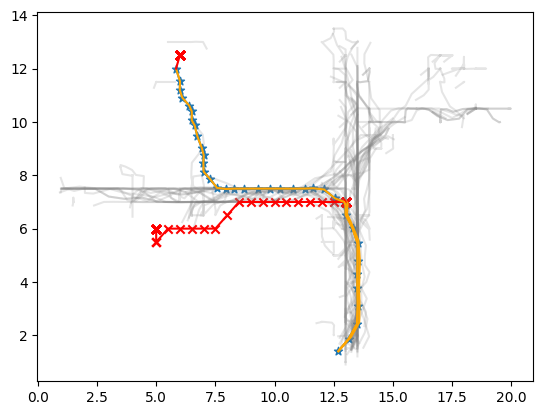

In [ ]:

# print(filtered_data.loc[track_id,:]['proj_x'])
_track_id =  8701 # random.choice(track_ids)
_track_id =  3880 # random.choice(track_ids)

# _track_id = 2780

for batch_idx in range(100):
    _track_id = random.choice(track_ids)
    plt.plot(
        data.loc[_track_id,:]['x'],
        data.loc[_track_id,:]['y'],
        c='grey', alpha=.2
    )

_track_id = random.choice(track_ids)
# _track_id = 1096
_track_id = 1301
print(_track_id)
ax = plt.scatter(
    data.loc[_track_id,:]['x'],
    data.loc[_track_id,:]['y'],
    marker="*") 
plt.plot(
    data.loc[_track_id,:]['x'],
    data.loc[_track_id,:]['y']
)

X = data.loc[_track_id,:].iloc[:][in_fields].values
# Adding randomness might be a cheat to get multiple features from current position
rnd = np.random.random_sample(X.shape) / 10
# print(rnd)

print(X[:10].shape, (X[:10] + rnd[:10]).shape)

# predict_and_plot(data.loc[_track_id,:].iloc[:5][in_fields].values)
# predict_and_plot(model, data.loc[_track_id,:].iloc[:5][in_fields].values, 50)
# predict_and_plot(model, data.loc[_track_id,:].iloc[:10][in_fields].values, 50)
# predict_and_plot(model, data.loc[_track_id,:].iloc[:20][in_fields].values)
# predict_and_plot(model, data.loc[_track_id,:].iloc[:30][in_fields].values)
predict_and_plot(model, X[:12])
predict_and_plot(model, X[:12] + rnd[:12])
predict_and_plot(model, data.loc[_track_id,:].iloc[:][in_fields].values)
# predict_and_plot(filtered_data.loc[_track_id,:].iloc[:70][in_fields].values)
# predict_and_plot(filtered_data.loc[_track_id,:].iloc[:115][in_fields].values)

## VAE

In [ ]:
# From https://github.com/CUN-bjy/lstm-vae-torch/blob/main/src/models.py (MIT)

from typing import Optional


class Encoder(nn.Module):
    def __init__(self, input_size=4096, hidden_size=1024, num_layers=2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
        )

    def get_hidden_state(self, batch_size, device):
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return (h, c)

    def forward(self, x, hidden_state):
        # x: tensor of shape (batch_size, seq_length, hidden_size)
        outputs, (hidden, cell) = self.lstm(x, hidden_state)
        return outputs, (hidden, cell)


class Decoder(nn.Module):
    def __init__(
        self, input_size=4096, hidden_size=1024, output_size=4096, num_layers=2
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
        )
        self.fc = nn.Linear(hidden_size, output_size)
    
    def get_hidden_state(self, batch_size, device):
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return (h, c)

    def forward(self, x, hidden):
        # x: tensor of shape (batch_size, seq_length, hidden_size)
        output, (hidden, cell) = self.lstm(x, hidden)
        prediction = self.fc(output)
        return prediction, (hidden, cell)


class LSTMVAE(nn.Module):
    """LSTM-based Variational Auto Encoder"""

    def __init__(
        self, input_size, output_size, hidden_size, latent_size, device=torch.device("cuda")
    ):
        """
        input_size: int, batch_size x sequence_length x input_dim
        hidden_size: int, output size of LSTM AE
        latent_size: int, latent z-layer size
        num_lstm_layer: int, number of layers in LSTM
        """
        super(LSTMVAE, self).__init__()
        self.device = device

        # dimensions
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = 1

        # lstm ae
        self.lstm_enc = Encoder(
            input_size=input_size, hidden_size=hidden_size, num_layers=self.num_layers
        )
        self.lstm_dec = Decoder(
            input_size=latent_size,
            output_size=output_size,
            hidden_size=hidden_size,
            num_layers=self.num_layers,
        )

        self.fc21 = nn.Linear(self.hidden_size, self.latent_size)
        self.fc22 = nn.Linear(self.hidden_size, self.latent_size)
        self.fc3 = nn.Linear(self.latent_size, self.hidden_size)

    def reparametize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        noise = torch.randn_like(std).to(self.device)

        z = mu + noise * std
        return z

    def forward(self, x, hidden_state_encoder: Optional[tuple]=None):
        batch_size, seq_len, feature_dim = x.shape

        if hidden_state_encoder is None:
            hidden_state_encoder = self.lstm_enc.get_hidden_state(batch_size, self.device)

        # encode input space to hidden space
        prediction, hidden_state = self.lstm_enc(x, hidden_state_encoder)
        enc_h = hidden_state[0].view(batch_size, self.hidden_size).to(self.device)

        # extract latent variable z(hidden space to latent space)
        mean = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparametize(mean, logvar)  # batch_size x latent_size

        # initialize hidden state as inputs
        h_ = self.fc3(z)
        
        # decode latent space to input space
        z = z.repeat(1, seq_len, 1)
        z = z.view(batch_size, seq_len, self.latent_size).to(self.device)

        # initialize hidden state
        hidden = (h_.contiguous(), h_.contiguous())
        # TODO)) the above is not the right dimensions, but this changes architecture
        hidden = self.lstm_dec.get_hidden_state(batch_size, self.device)
        reconstruct_output, hidden = self.lstm_dec(z, hidden)

        x_hat = reconstruct_output
        
        return x_hat, hidden_state, mean, logvar

    def loss_function(self, *args, **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        predicted = args[0]
        target = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = 0.00025  # Account for the minibatch samples from the dataset
        recons_loss = torch.nn.functional.mse_loss(predicted, target=target)

        kld_loss = torch.mean(
            -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0
        )

        loss = recons_loss + kld_weight * kld_loss
        return {
            "loss": loss,
            "Reconstruction_Loss": recons_loss.detach(),
            "KLD": -kld_loss.detach(),
        }


In [303]:
vae = LSTMVAE(input_size, output_size, hidden_size,  1024, device=device)
vae.to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

In [304]:
def train_vae(model, train_loader, test_loader, max_iter, learning_rate):
    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    ## interation setup
    epochs = tqdm(range(max_iter // len(train_loader) + 1))
    epochs = tqdm(range(max_iter))

    ## training
    count = 0
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()
        train_iterator = tqdm(
            enumerate(train_loader), total=len(train_loader), desc="training"
        )

        # if count > max_iter:
        #     print("max!")
        #     return model

        for batch_idx, (x, targets) in train_iterator:
            count += 1

            # future_data, past_data = batch_data

            ## reshape
            batch_size = x.size(0)
            example_size = x.size(1)
            # image_size = past_data.size(2), past_data.size(3)
            # past_data = (
            #     past_data.view(batch_size, example_size, -1).float().to(args.device) # flattens image, we don't need this
            # )
            # future_data = future_data.view(batch_size, example_size, -1).float().to(args.device)

            y, hidden_state, mean, logvar = model(x)

            # calculate vae loss
            # print(y.shape, targets.shape)
            losses = model.loss_function(y, targets, mean, logvar)
            mloss, recon_loss, kld_loss = (
                losses["loss"],
                losses["Reconstruction_Loss"],
                losses["KLD"],
            )

            # Backward and optimize
            optimizer.zero_grad()
            mloss.mean().backward()
            optimizer.step()

            train_iterator.set_postfix({"train_loss": float(mloss.mean())})
        print("train_loss", float(mloss.mean()), epoch)

        model.eval()
        eval_loss = 0
        test_iterator = tqdm(
            enumerate(test_loader), total=len(test_loader), desc="testing"
        )

        with torch.no_grad():
            for batch_idx, (x, targets) in test_iterator:
                # future_data, past_data = batch_data

                ## reshape
                batch_size = x.size(0)
                example_size = x.size(1)
                # past_data = (
                #     past_data.view(batch_size, example_size, -1).float().to(args.device)
                # )
                # future_data = future_data.view(batch_size, example_size, -1).float().to(args.device)

                y, hidden_state, mean, logvar = model(x)

                # calculate vae loss
                losses = model.loss_function(y, targets, mean, logvar)
                mloss, recon_loss, kld_loss = (
                    losses["loss"],
                    losses["Reconstruction_Loss"],
                    losses["KLD"],
                )

                eval_loss += mloss.mean().item()

                test_iterator.set_postfix({"eval_loss": float(mloss.mean())})

                # if batch_idx == 0:
                #     nhw_orig = past_data[0].view(example_size, image_size[0], -1)
                #     nhw_recon = recon_x[0].view(example_size, image_size[0], -1)
                #     imshow(nhw_orig.cpu(), f"orig{epoch}")
                #     imshow(nhw_recon.cpu(), f"recon{epoch}")
                    # writer.add_images(f"original{i}", nchw_orig, epoch)
                    # writer.add_images(f"reconstructed{i}", nchw_recon, epoch)

        eval_loss = eval_loss / len(test_loader)
        # writer.add_scalar("eval_loss", float(eval_loss), epoch)
        print("Evaluation Score : [{}]".format(eval_loss))

    print("Done :-)")
    return model

In [305]:
train_vae(vae, loader_train, loader_test, num_epochs, learning_rate*10)

  0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: For batched 3-D input, hx and cx should also be 3-D but got (2-D, 2-D) tensors

1301


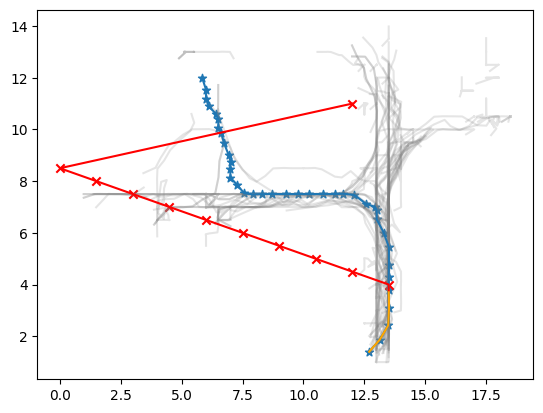

In [300]:
# VAE Predict and plot
_track_id =  8701 # random.choice(track_ids)
_track_id =  3880 # random.choice(track_ids)

# _track_id = 2780

for batch_idx in range(100):
    _track_id = random.choice(track_ids)
    plt.plot(
        data.loc[_track_id,:]['x'],
        data.loc[_track_id,:]['y'],
        c='grey', alpha=.2
    )

_track_id = random.choice(track_ids)
# _track_id = 1096
_track_id = 1301
print(_track_id)
ax = plt.scatter(
    data.loc[_track_id,:]['x'],
    data.loc[_track_id,:]['y'],
    marker="*") 
plt.plot(
    data.loc[_track_id,:]['x'],
    data.loc[_track_id,:]['y']
)

# predict_and_plot(data.loc[_track_id,:].iloc[:5][in_fields].values)
predict_and_plot(vae, data.loc[_track_id,:].iloc[:5][in_fields].values, 50)
# predict_and_plot(vae, data.loc[_track_id,:].iloc[:10][in_fields].values, 50)
# predict_and_plot(vae, data.loc[_track_id,:].iloc[:20][in_fields].values)
# predict_and_plot(vae, data.loc[_track_id,:].iloc[:30][in_fields].values)
# predict_and_plot(filtered_data.loc[_track_id,:].iloc[:70][in_fields].values)
# predict_and_plot(filtered_data.loc[_track_id,:].iloc[:115][in_fields].values)

In [ ]:
# import torch

class VAE_Loss(torch.nn.Module):
  """
  Adapted from https://github.com/Khamies/LSTM-Variational-AutoEncoder/blob/main/model.py
  """
  def __init__(self):
    super(VAE_Loss, self).__init__()
    self.nlloss = torch.nn.NLLLoss()
  
  def KL_loss (self, mu, log_var, z):
    kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    kl = kl.sum(-1)  # to go from multi-dimensional z to single dimensional z : (batch_size x latent_size) ---> (batch_size) 
                                                                      # i.e Z = [ [z1_1, z1_2 , ...., z1_lt] ] ------> z = [ z1] 
                                                                      #         [ [z2_1, z2_2, ....., z2_lt] ]             [ z2]
                                                                      #                   .                                [ . ]
                                                                      #                   .                                [ . ]
                                                                      #         [[zn_1, zn_2, ....., zn_lt] ]              [ zn]
                                                                      
                                                                      #        lt=latent_size 
    kl = kl.mean()
                                                                      
    return kl

  def reconstruction_loss(self, x_hat_param, x):

    x = x.view(-1).contiguous()
    x_hat_param = x_hat_param.view(-1, x_hat_param.size(2))

    recon = self.nlloss(x_hat_param, x)

    return recon
  

  def forward(self, mu, log_var,z, x_hat_param, x):
    kl_loss = self.KL_loss(mu, log_var, z)
    recon_loss = self.reconstruction_loss(x_hat_param, x)


    elbo = kl_loss + recon_loss # we use + because recon loss is a NLLoss (cross entropy) and it's negative in its own, and in the ELBO equation we have
                              # elbo = KL_loss - recon_loss, therefore, ELBO = KL_loss - (NLLoss) = KL_loss + NLLoss

    return elbo, kl_loss, recon_loss
  
class LSTM_VAE(torch.nn.Module):
  """
  Adapted from https://github.com/Khamies/LSTM-Variational-AutoEncoder/blob/main/model.py
  """
  def __init__(self, input_size, output_size, hidden_size, latent_size, num_layers=1, device="cuda"):
    super(LSTM_VAE, self).__init__()

    self.device = device
    
    # Variables
    self.num_layers = num_layers
    self.lstm_factor = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.latent_size = latent_size
    self.output_size = output_size

    #    X: bsz * seq_len * vocab_size 
    #    X: bsz * seq_len * embed_size

    # Encoder Part
    self.encoder_lstm = torch.nn.LSTM(input_size= input_size,hidden_size= self.hidden_size, batch_first=True, num_layers= self.num_layers)
    self.mean = torch.nn.Linear(in_features= self.hidden_size * self.lstm_factor, out_features= self.latent_size)
    self.log_variance = torch.nn.Linear(in_features= self.hidden_size * self.lstm_factor, out_features= self.latent_size)

    # Decoder Part
                                        
    self.hidden_decoder_linear = torch.nn.Linear(in_features= self.latent_size, out_features= self.hidden_size * self.lstm_factor)
    self.decoder_lstm = torch.nn.LSTM(input_size= self.embed_size, hidden_size= self.hidden_size, batch_first = True, num_layers = self.num_layers)
    self.output = torch.nn.Linear(in_features= self.hidden_size * self.lstm_factor, out_features= self.output_size)
    # self.log_softmax = torch.nn.LogSoftmax(dim=2)

  def get_hidden_state(self, batch_size):
    h = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)
    c = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)
    return (h, c)


  def encoder(self, x, hidden_state):

    # pad the packed input.

    out, (h,c) = self.encoder_lstm(x, hidden_state)
    # output_encoder, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_output_encoder, batch_first=True, total_length= total_padding_length)

    # Extimate the mean and the variance of q(z|x)
    mean = self.mean(h)
    log_var = self.log_variance(h)
    std = torch.exp(0.5 * log_var)   # e^(0.5 log_var) = var^0.5
    
    # Generate a unit gaussian noise.
    # batch_size = output_encoder.size(0)
    # seq_len = output_encoder.size(1)
    # noise = torch.randn(batch_size, self.latent_size).to(self.device)
    noise = torch.randn(self.latent_size).to(self.device)
    
    z = noise * std + mean

    return z, mean, log_var, (h,c)


  def decoder(self, z, x):

    hidden_decoder = self.hidden_decoder_linear(z)
    hidden_decoder = (hidden_decoder, hidden_decoder)

    # pad the packed input.
    packed_output_decoder, hidden_decoder = self.decoder_lstm(packed_x_embed,hidden_decoder) 
    output_decoder, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_output_decoder, batch_first=True, total_length= total_padding_length)


    x_hat = self.output(output_decoder)
    
    # x_hat = self.log_softmax(x_hat)


    return x_hat

  

  def forward(self, x, hidden_state):
    
    """
      x : bsz * seq_len
    
      hidden_encoder: ( num_lstm_layers * bsz * hidden_size, num_lstm_layers * bsz * hidden_size)

    """
    # Get Embeddings
    # x_embed, maximum_padding_length = self.get_embedding(x)

    # Packing the input
    # packed_x_embed = torch.nn.utils.rnn.pack_padded_sequence(input= x_embed, lengths= sentences_length, batch_first=True, enforce_sorted=False)


    # Encoder
    z, mean, log_var, hidden_encoder = self.encoder(x, maximum_padding_length, hidden_encoder)

    # Decoder
    x_hat = self.decoder(z, packed_x_embed, maximum_padding_length)
    
    return x_hat, mean, log_var, z, hidden_encoder

  

  def inference(self, n_samples, x, z):

    # generate random z 
    batch_size = 1
    seq_len = 1
    idx_sample = []


    hidden = self.hidden_decoder_linear(z)
    hidden = (hidden, hidden)
    
    for i in range(n_samples):
      
      output,hidden = self.decoder_lstm(x, hidden)
      output = self.output(output)
      # output = self.log_softmax(output)
      # output = output.exp()
      _, s = torch.topk(output, 1)
      idx_sample.append(s.item())
      x = s.squeeze(0)

    w_sample = [self.dictionary.get_i2w()[str(idx)] for idx in idx_sample]
    w_sample = " ".join(w_sample)

    return w_sample



def get_batch(batch):
  sentences = batch["input"]
  target = batch["target"]
  sentences_length = batch["length"]

  return sentences, target, sentences_length

class Trainer:

    def __init__(self, train_loader, test_loader, model, loss, optimizer) -> None:
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.interval = 200


    def train(self, train_losses, epoch, batch_size, clip) -> list:  
        # Initialization of RNN hidden, and cell states.
        states = self.model.init_hidden(batch_size) 

        for batch_idx, (x, targets) in enumerate(self.train_loader):
            # Get x to cuda if possible
            x = x.to(device=device).squeeze(1)
            targets = targets.to(device=device)

        # for batch_num, batch in enumerate(self.train_loader): # loop over the data, and jump with step = bptt.
            # get the labels
            source, target, source_lengths = get_batch(batch)
            source = source.to(self.device)
            target = target.to(self.device)


            x_hat_param, mu, log_var, z, states = self.model(source,source_lengths, states)

            # detach hidden states
            states = states[0].detach(), states[1].detach()

            # compute the loss
            mloss, KL_loss, recon_loss = self.loss(mu = mu, log_var = log_var, z = z, x_hat_param = x_hat_param , x = target)

            train_losses.append((mloss , KL_loss.item(), recon_loss.item()))

            mloss.backward()

            torch.nn.utils.clip_grad_norm_(self.model.parameters(), clip)

            self.optimizer.step()

            self.optimizer.zero_grad()


            if batch_num % self.interval == 0 and batch_num > 0:
  
                print('| epoch {:3d} | elbo_loss {:5.6f} | kl_loss {:5.6f} | recons_loss {:5.6f} '.format(
                    epoch, mloss.item(), KL_loss.item(), recon_loss.item()))

        return train_losses

    def test(self, test_losses, epoch, batch_size) -> list:

        with torch.no_grad():

            states = self.model.init_hidden(batch_size) 

            for batch_num, batch in enumerate(self.test_loader): # loop over the data, and jump with step = bptt.
                # get the labels
                source, target, source_lengths = get_batch(batch)
                source = source.to(self.device)
                target = target.to(self.device)


                x_hat_param, mu, log_var, z, states = self.model(source,source_lengths, states)

                # detach hidden states
                states = states[0].detach(), states[1].detach()

                # compute the loss
                mloss, KL_loss, recon_loss = self.loss(mu = mu, log_var = log_var, z = z, x_hat_param = x_hat_param , x = target)

                test_losses.append((mloss , KL_loss.item(), recon_loss.item()))

                # Statistics.
                # if batch_num % 20 ==0:
                #   print('| epoch {:3d} | elbo_loss {:5.6f} | kl_loss {:5.6f} | recons_loss {:5.6f} '.format(
                #         epoch, mloss.item(), KL_loss.item(), recon_loss.item()))

            return test_losses

vae = LSTM_VAE(input_size, output_size, hidden_size, 16, 1, device).to(device)

vae_loss = VAE_Loss()
optimizer = torch.optim.Adam(vae.parameters(), lr= learning_rate)

trainer = Trainer(loader_train, loader_test, vae, vae_loss, optimizer)




AttributeError: 'LSTM_VAE' object has no attribute 'embed_size'